In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
import torch.optim as optim
from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import random
from sklearn.decomposition import NMF
import os
import csv

In [3]:
# import labels for the shapes
shape_labels = np.genfromtxt('../FiltrationsForGNNs/Gudhi Shape Dataset/shape_labels.csv', delimiter=',', skip_header=1)
shape_labels_num = shape_labels.astype(int)[:,0]
shape_labels = shape_labels.astype(int)[:,2]

print(shape_labels)
print(shape_labels_num)

[1 1 1 ... 0 0 0]
[1000 1001 1002 ... 4767 4768 4769]


C:\Users\alanp\AppData\Local\Temp\ipykernel_100620\3679495408.py:3: RuntimeWarning: invalid value encountered in cast
  shape_labels_num = shape_labels.astype(int)[:,0]
C:\Users\alanp\AppData\Local\Temp\ipykernel_100620\3679495408.py:4: RuntimeWarning: invalid value encountered in cast
  shape_labels = shape_labels.astype(int)[:,2]


In [4]:
shape_labels.shape

(3157,)

In [10]:
num_samples = len(shape_labels) # currently set to full dataset

# Generate random indices
random_indices = list(range(num_samples))
base = '../FiltrationsForGNNs/Gudhi Shape Dataset'
# Select the corresponding data and labels
laplacians = []
vr_persistence_images = []
abstract_persistence_images = []
selected_labels = []

for i in random_indices:
    if os.path.exists(f"{base}/shape_{shape_labels_num[i]}_laplacian.csv"):
        laplacians.append(np.genfromtxt(f'{base}/shape_{shape_labels_num[i]}_laplacian.csv', delimiter=',', skip_header=0))
        vr_persistence_images.append(np.genfromtxt(f'{base}/shape_{shape_labels_num[i]}_vr_persistence_image.csv', delimiter=',', skip_header=0))
        abstract_persistence_images.append(np.genfromtxt(f'{base}/shape_{shape_labels_num[i]}_abstract_persistence_image.csv', delimiter=',', skip_header=0))
        selected_labels.append(shape_labels[i])

# Convert selected labels to NumPy array
selected_labels = np.array(selected_labels)

# Print a summary
print(f"Randomly selected {num_samples} samples.")
print(f"Shape of laplacians: {np.array(laplacians).shape}")
print(f"Shape of VR persistence images: {np.array(vr_persistence_images).shape}")
print(f"Shape of abstract persistence images: {np.array(abstract_persistence_images).shape}")
print(f"Shape of selected labels: {selected_labels.shape}")

In [13]:
with open('Laplacians.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(laplacians)

with open('OriginalAbstract.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(abstract_persistence_images)

with open('OriginalVR.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(vr_persistence_images)

with open('Selected_Labels.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(selected_labels)

In [41]:
len(selected_labels)
len(vr_persistence_images)

3153

In [37]:
a = [(vr_persistence_images[0], shape_labels[0]), (vr_persistence_images[1], shape_labels[1])]
a[0][1]

1

In [6]:
vr_0 = []
vr_1 = []
abstract0 = []
abstract1 = []
for i in range(len(selected_labels)):
    if selected_labels[i] == 0:
        vr_0.append(vr_persistence_images[i])
        abstract0.append(abstract_persistence_images[i])
    else:
        vr_1.append(vr_persistence_images[i])
        abstract1.append(abstract_persistence_images[i])

In [78]:
class CNN(nn.Module):
    def __init__(self, input_shape, num_classes=2):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Adaptive Pooling to resize to 100x100
        self.adaptive_pool = nn.AdaptiveAvgPool2d((100, 100))
        
        # Dynamically calculate input size to fc1
        self.feature_size = self._get_feature_size(input_shape)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(self.feature_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_feature_size(self, input_shape):
        # Create a dummy input to calculate size after conv and pooling
        dummy_input = torch.zeros(1, 1, *input_shape)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Apply adaptive pooling to get 100x100 size
        x = self.adaptive_pool(x)
        return x.numel()  # Number of elements after flattening

    def forward(self, x):
        # Apply convolutional layers with pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Apply adaptive pooling to resize to 100x100
        x = self.adaptive_pool(x)
        
        # Flatten and pass through fully connected layers
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [74]:
def single_viz(model, data, name, d):
    model.eval()
    model_weights =[]
    conv_layers = []

    model_children = list(model.children())
    counter = 0

    for child in range(len(model_children)):
        if type(model_children[child]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[child].weight)
            conv_layers.append(model_children[child])
    image = np.float32(laplacians)
    image = torch.tensor(image)
    outputs = []
    names = []

    for layer in conv_layers:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))
    #print feature_maps
    for feature_map in outputs:
        print(feature_map.shape)
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    for fm in processed:
        print(fm.shape)
    fig = plt.figure(figsize=(30, 50))
    a = fig.add_subplot(1,3,1)
    a.set_title(f"{name} {d} dimensional", fontsize=30)
    implot = plt.imshow(data[0])
    for i in range(len(processed)):
        a = fig.add_subplot(1, 3, i + 2)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(f"Conv Layer {i + 1}", fontsize=30)  # Adjust subplot title font size
    fig.savefig(
    f"{name}_{d}",
    bbox_inches="tight",  # Crop extra white space
    pad_inches=0.1,       # Add a small padding around the figure
    dpi=300               # Increase resolution (optional)
)

torch.Size([16, 1000, 1000])
torch.Size([32, 1000, 1000])


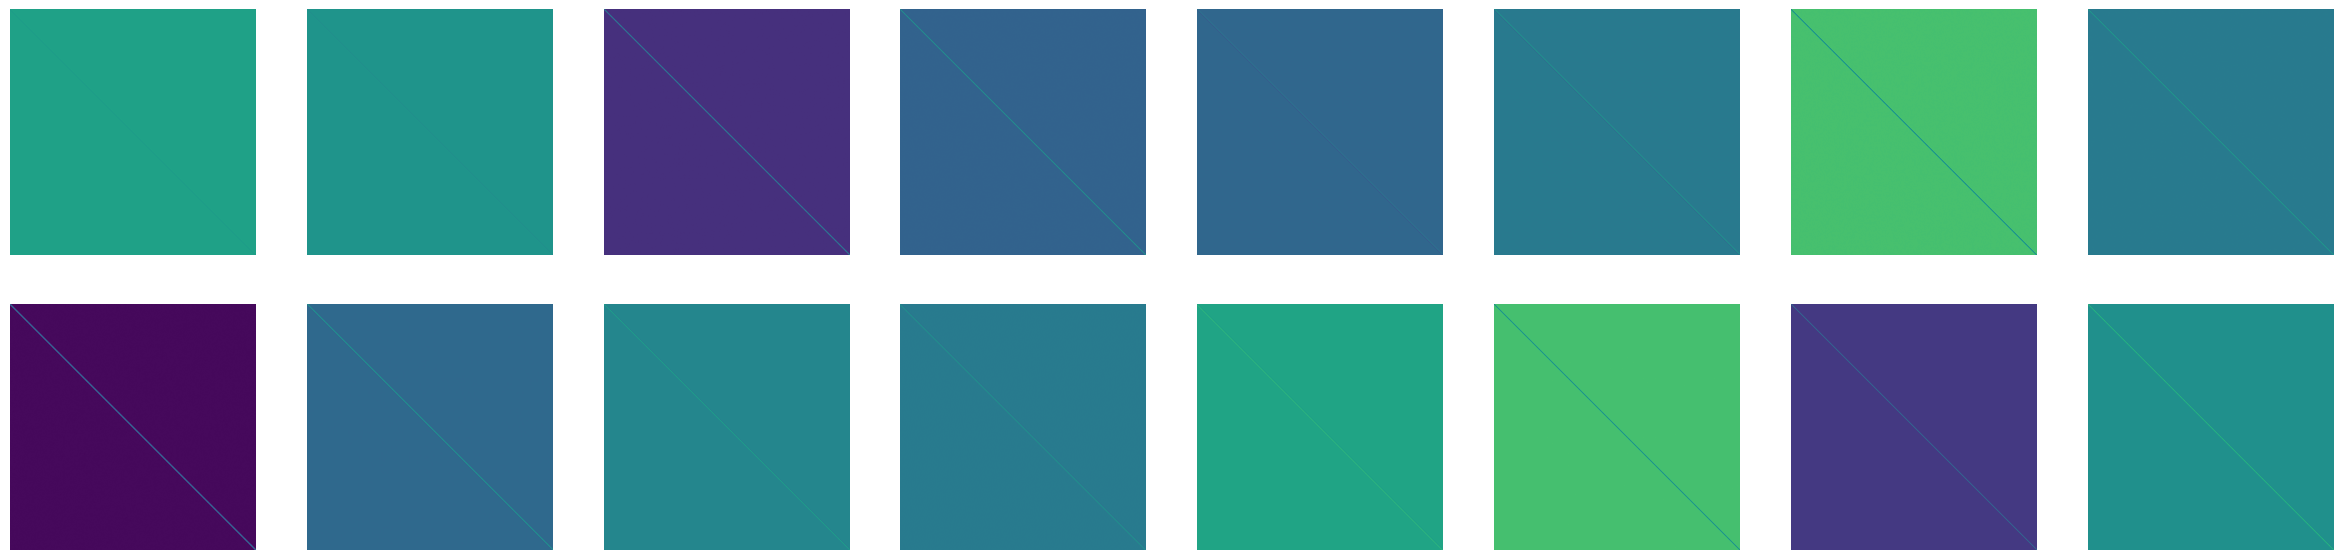

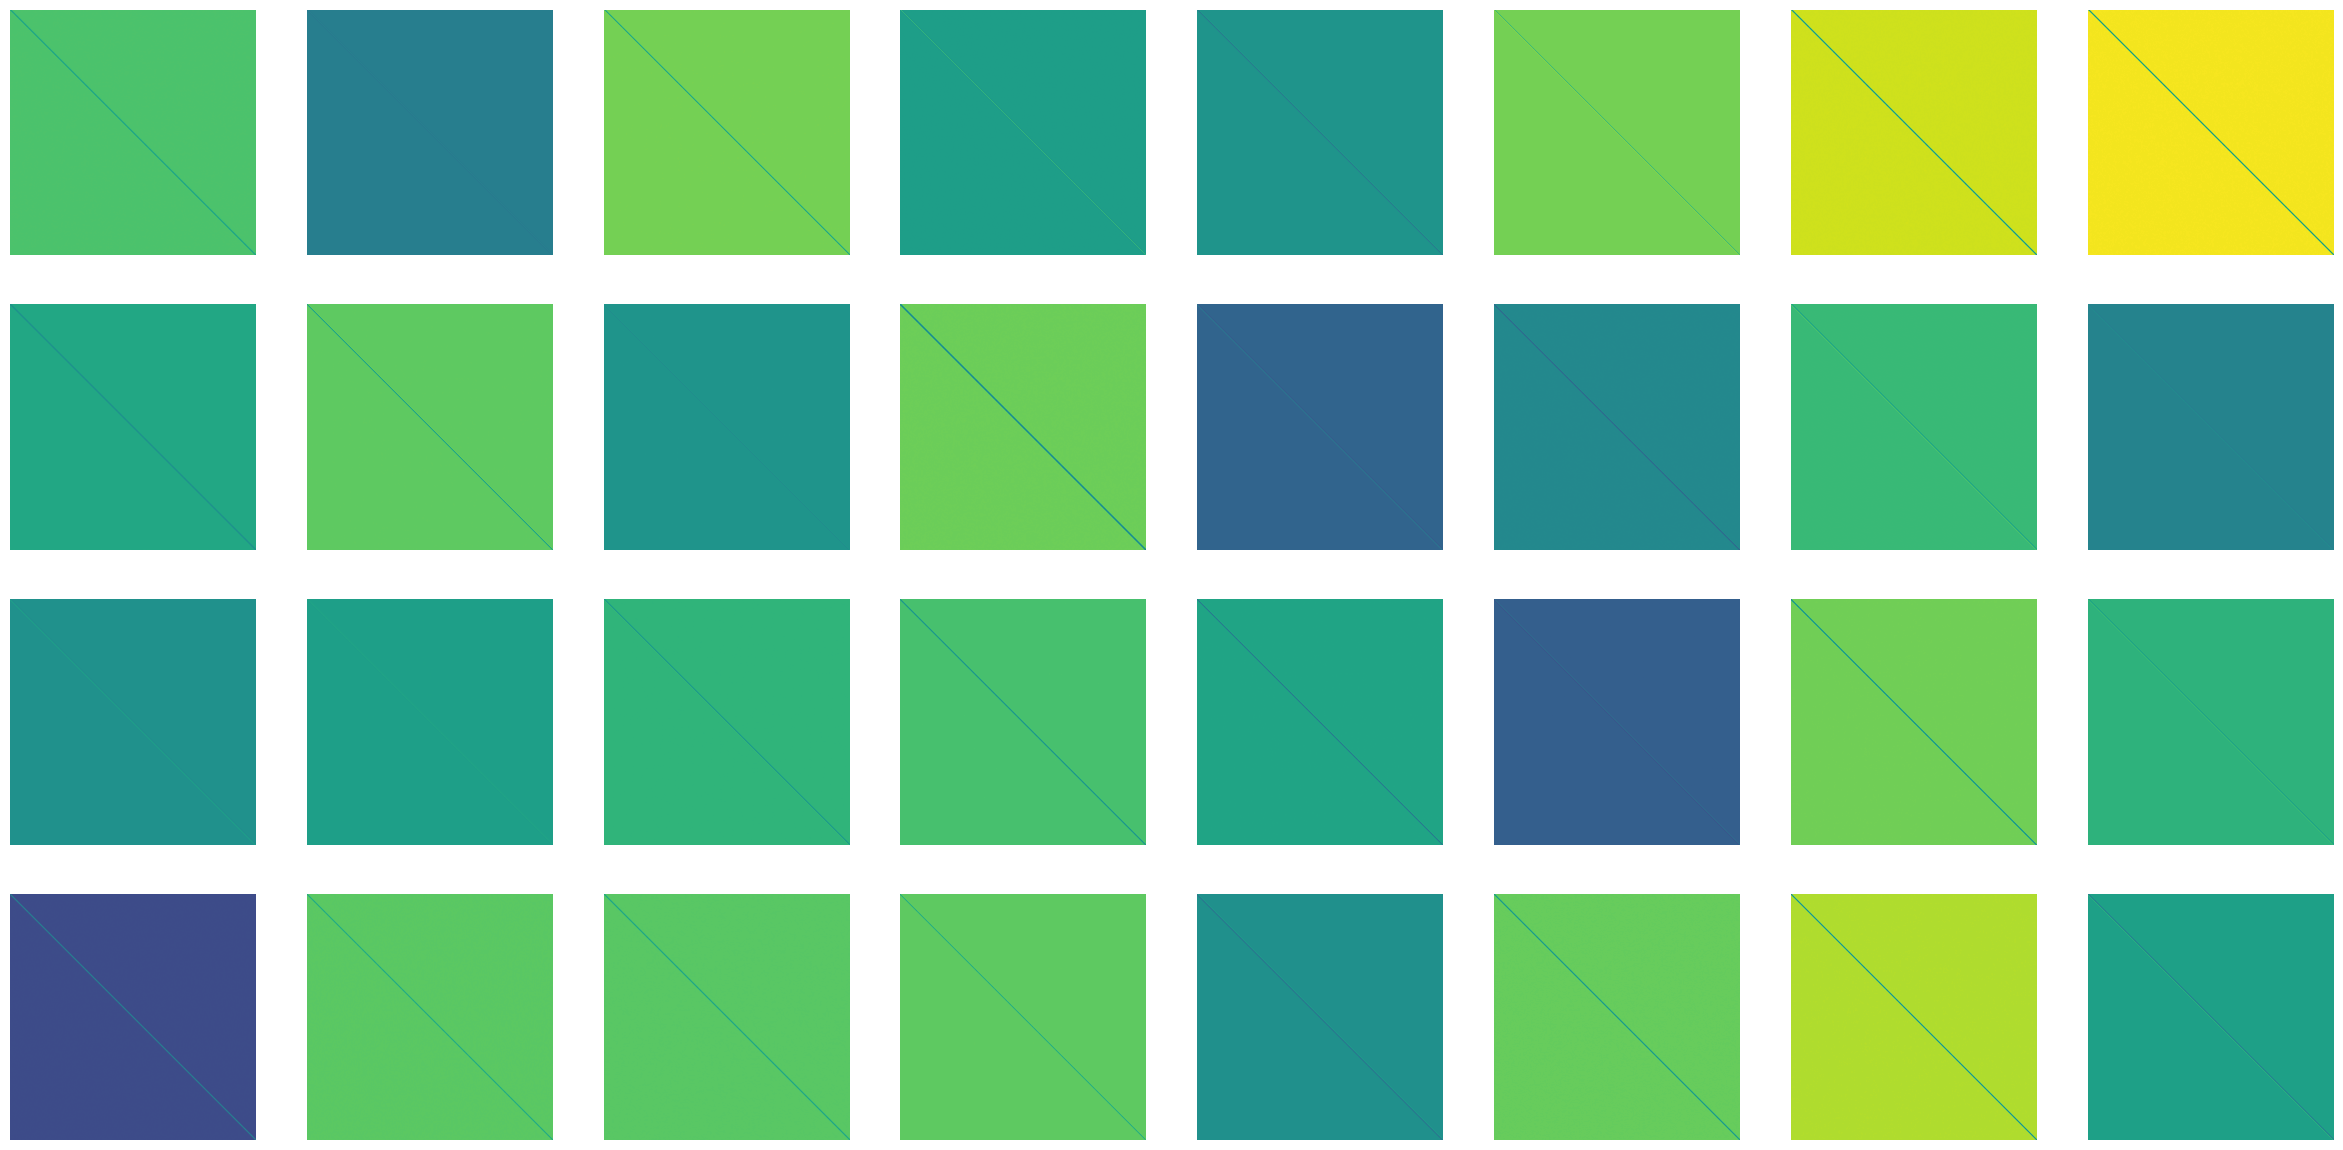

In [83]:
lap.eval()
model_weights =[]
conv_layers = []

model_children = list(lap.children())
counter = 0

for child in range(len(model_children)):
    if type(model_children[child]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[child].weight)
        conv_layers.append(model_children[child])


image = np.float32(laplacians)
image = torch.tensor(image)
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][:, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter)
        plt.axis("off")

In [20]:
image = np.float32(laplacians)
image = torch.tensor(image)
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [ ]:
outputs[0][][:][:]

tensor([[ 9.0789e-01,  3.3283e+01, -5.9390e+00,  ...,  1.2698e-01,
          1.2698e-01,  1.2698e-01],
        [ 1.5179e+01,  2.9386e+01,  3.3739e+01,  ...,  1.2698e-01,
          1.2698e-01,  1.2698e-01],
        [ 1.4125e+01,  1.5466e+01,  3.2551e+01,  ...,  1.8421e-01,
          1.2698e-01,  1.2698e-01],
        ...,
        [ 1.2698e-01,  1.2698e-01, -5.0715e-03,  ...,  2.6057e+01,
          2.9642e+01, -5.2842e+00],
        [ 1.2698e-01,  1.2698e-01,  1.2698e-01,  ...,  1.4660e+01,
          2.8012e+01,  2.7897e+01],
        [ 1.2698e-01,  1.2698e-01,  1.2698e-01,  ...,  1.1738e+01,
          1.2685e+01,  4.0314e+01]], grad_fn=<SliceBackward0>)

In [11]:
class DualInputCNN(nn.Module):
    def __init__(self, input_shape1, input_shape2, num_classes=2):
        super(DualInputCNN, self).__init__()

        # Laplacian input path with additional pooling to reduce to 100x100
        self.conv1_lap = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_lap = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool_lap = nn.MaxPool2d(2, 2)  # Reduce spatial dimensions
        self.adaptive_pool_lap = nn.AdaptiveAvgPool2d((100, 100))  # Resize to 100x100
        
        # Persistence image input path (no pooling)
        self.conv1_pers = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_pers = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.adaptive_pool_pers = nn.AdaptiveAvgPool2d((100, 100))  # Resize to 100x100
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 100 * 100 + 32 * 100 * 100, 128)  # Adjusted for 100x100 input
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x1, x2):
        # Laplacians path (downsampling to 100x100)
        x1 = F.relu(self.conv1_lap(x1))
        x1 = self.pool_lap(x1)  # First pool: 250x250 -> 125x125
        x1 = F.relu(self.conv2_lap(x1))
        x1 = self.pool_lap(x1)  # Second pool: 125x125 -> 62x62
        x1 = self.adaptive_pool_lap(x1)  # Resize to 100x100
        
        # Persistence images path (no pooling)
        x2 = F.relu(self.conv1_pers(x2))
        x2 = F.relu(self.conv2_pers(x2))
        x2 = self.adaptive_pool_pers(x2)  # Ensure persistence images are 100x100
        
        # Concatenate along dim=1 (channels)
        x = torch.cat((x1, x2), dim=1)  # Concatenates the outputs along the channel axis

        # Flatten for fully connected layer
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


In [14]:

num_classes = 2 # binary classification

# For dual-input CNNs (Laplacians + VR Persistence Images, Laplacians + Abstract Persistence Images)
input_shape1 = laplacians[0].shape
input_shape2 = vr_persistence_images[0].shape
input_shape3 = abstract_persistence_images[0].shape

model_dual_lap_vr_uni_nonuni = DualInputCNN(input_shape1, input_shape2, num_classes)
model_dual_lap_abstract_uni_nonuni = DualInputCNN(input_shape1, input_shape3, num_classes)

In [15]:
model_dual_lap_abstract_uni_nonuni.load_state_dict(torch.load('model_dual_h0_lap_abstract_unif_nonunif_gudhi_epoch_10.pth.', weights_only=True))
model_dual_lap_vr_uni_nonuni.load_state_dict(torch.load('model_dual_h0_lap_vr_unif_nonunif_gudhi_epoch_10.pth',weights_only=True))


<All keys matched successfully>

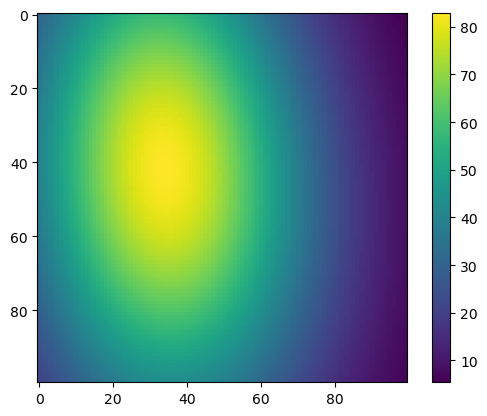

In [48]:
n = len(vr_0)
plt.imshow(sum(vr_0)/vr_0)
plt.colorbar()

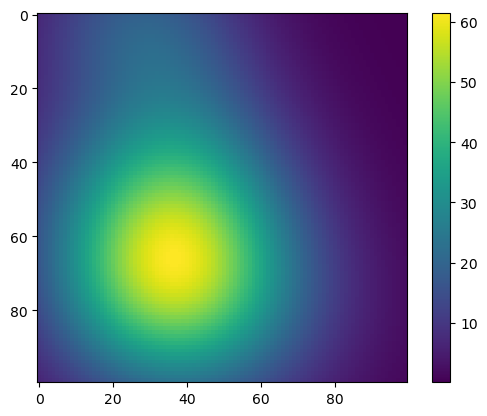

In [50]:
plt.imshow(sum(vr_1)/len(vr_1))

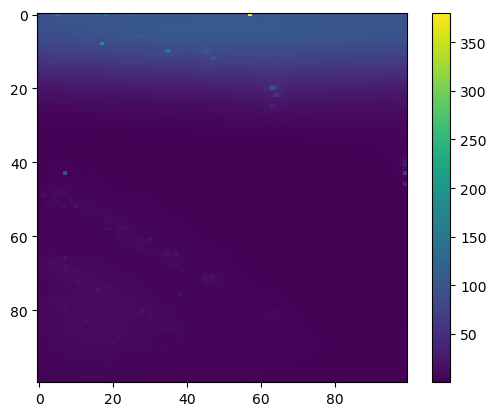

In [54]:
plt.imshow(sum(abstract0)/len(abstract0))
plt.colorbar()

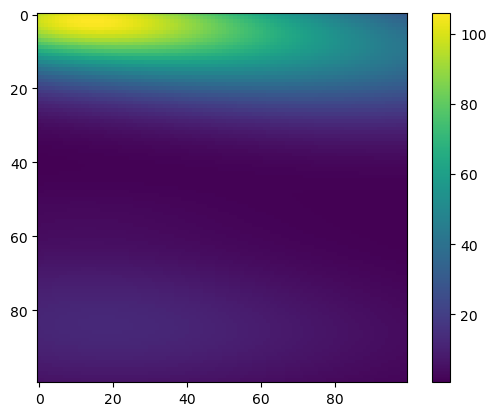

In [55]:
plt.imshow(sum(abstract1)/len(abstract1))
plt.colorbar()

In [83]:
process_vr_0 = image_preprocess(vr_0)

In [132]:
a = sum(process_vr_0)/len(process_vr_0)
a.detach().numpy()[0]

array([[30.239254 , 31.387138 , 32.54839  , ...,  6.1062164,  5.7448   ,
         5.40146  ],
       [30.667332 , 31.834673 , 33.015892 , ...,  6.2119293,  5.8442373,
         5.4949536],
       [31.090454 , 32.27712  , 33.478104 , ...,  6.3176126,  5.9436555,
         5.588422 ],
       ...,
       [21.678268 , 22.547039 , 23.429142 , ...,  7.157915 ,  6.767993 ,
         6.395032 ],
       [21.236849 , 22.086954 , 22.950024 , ...,  7.0496774,  6.6663527,
         6.2996573],
       [20.797815 , 21.629358 , 22.47354  , ...,  6.9407415,  6.5640445,
         6.203628 ]], dtype=float32)

In [55]:
def image_preprocess(image_list):
    l = []
    for i in range(len(image_list)):
        image = image_list[i]
        image = np.float32(image)
        image = torch.tensor(image)
        image = image.unsqueeze(0)
        l.append(image)
    return l

def average_visualization(model, data, name, d):
    average_original_image = sum(data)/len(data)
    model_weights = []
    conv_layers = []
    model.eval()
    processed_image = image_preprocess(data)
    model_children = list(model.children())
    #Get the children
    for child in range(len(model_children)):
        if type(model_children[child]) == nn.Conv2d:
            model_weights.append(model_children[child].weight)
            conv_layers.append(model_children[child])
    #use the layers to evaluate and save in each layer
    layer1 = []
    layer2 = []
    for i in range(len(processed_image)):
        ma = conv_layers[2:][0](processed_image[i])
        layer1.append(ma)
        ma = conv_layers[2:][1](ma)
        layer2.append(ma)
    
    layer1_processed = []
    layer2_processed = []
    for i in range(len(layer1)):
        layer1_processed.append(torch.sum(layer1[i],0))
    for i in range(len(layer2)):
        layer2_processed.append(torch.sum(layer2[i],0))

    final_image1 = sum(layer1_processed)/len(layer1_processed)
    final_image2 = sum(layer2_processed)/len(layer2_processed)

    final_image1 = final_image1.detach().numpy()
    final_image2 = final_image2.detach().numpy()
    #graph portion

    #original data average
    fig = plt.figure(figsize=(30, 50),layout='constrained')  # Large figure size
    a = fig.add_subplot(1,3,1)
    a.set_title(f"{name} Genus:{d} Average", fontsize=30)
    implot = plt.imshow(average_original_image)
    #First Layer Average plot
    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(final_image1)
    a.axis('off')
    a.set_title(f"Layer 1: Genus {d} Average", fontsize=30)
    #Second Layer Average plot
    a = fig.add_subplot(1,3,3)
    imgplot=plt.imshow(final_image2)
    a.axis('off')
    a.set_title(f"Layer 2: Genus {d} Average", fontsize=30)

    fig.savefig(
        f"{name}_{d}_Average.png",
        bbox_inches="tight",  # Crop extra white space
        pad_inches=0.1,       # Add a small padding around the figure
        dpi=300               # Increase resolution (optional)
    )
    plt.show()

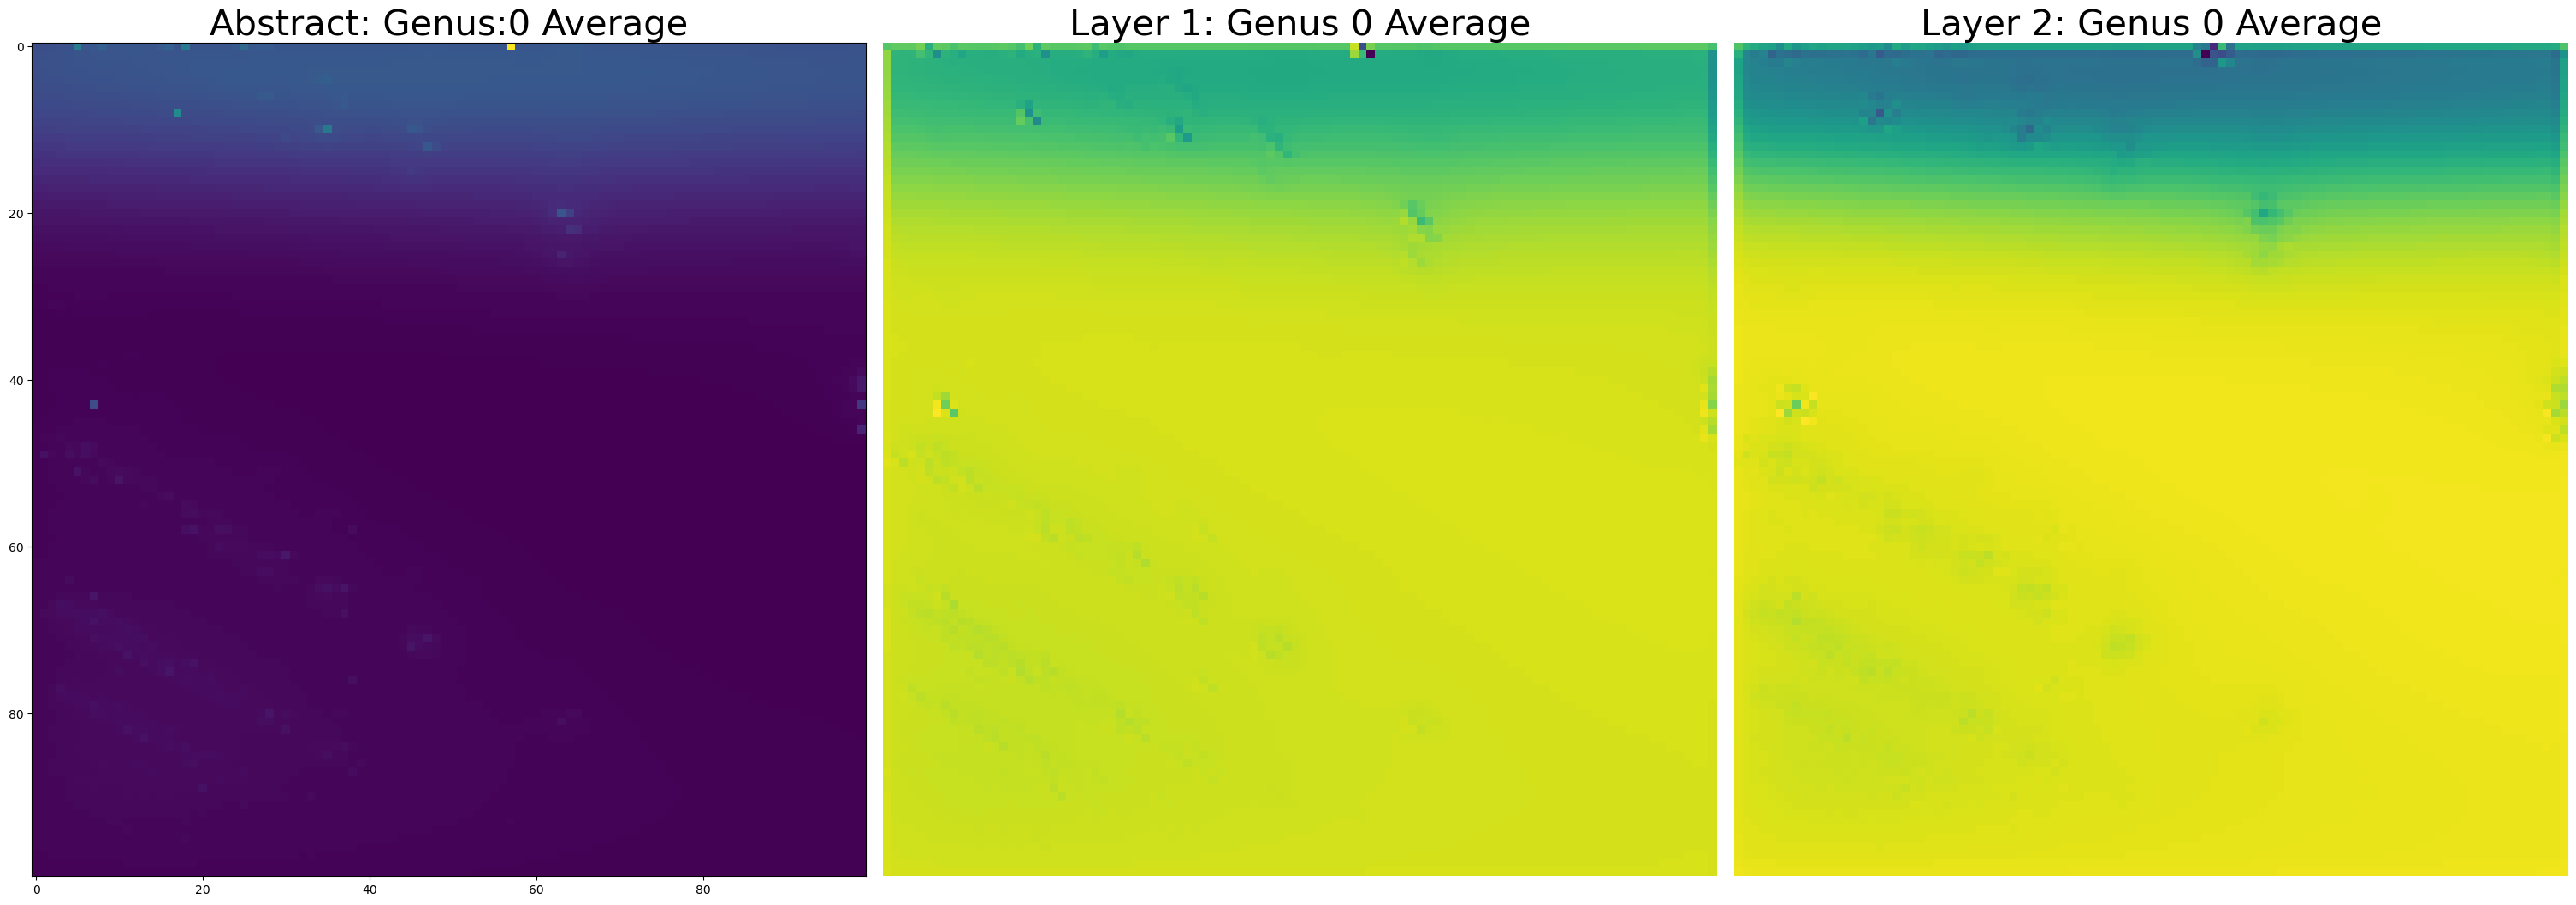

In [54]:
average_visualization(model_dual_lap_abstract_uni_nonuni, abstract0, "Abstract:", 0)

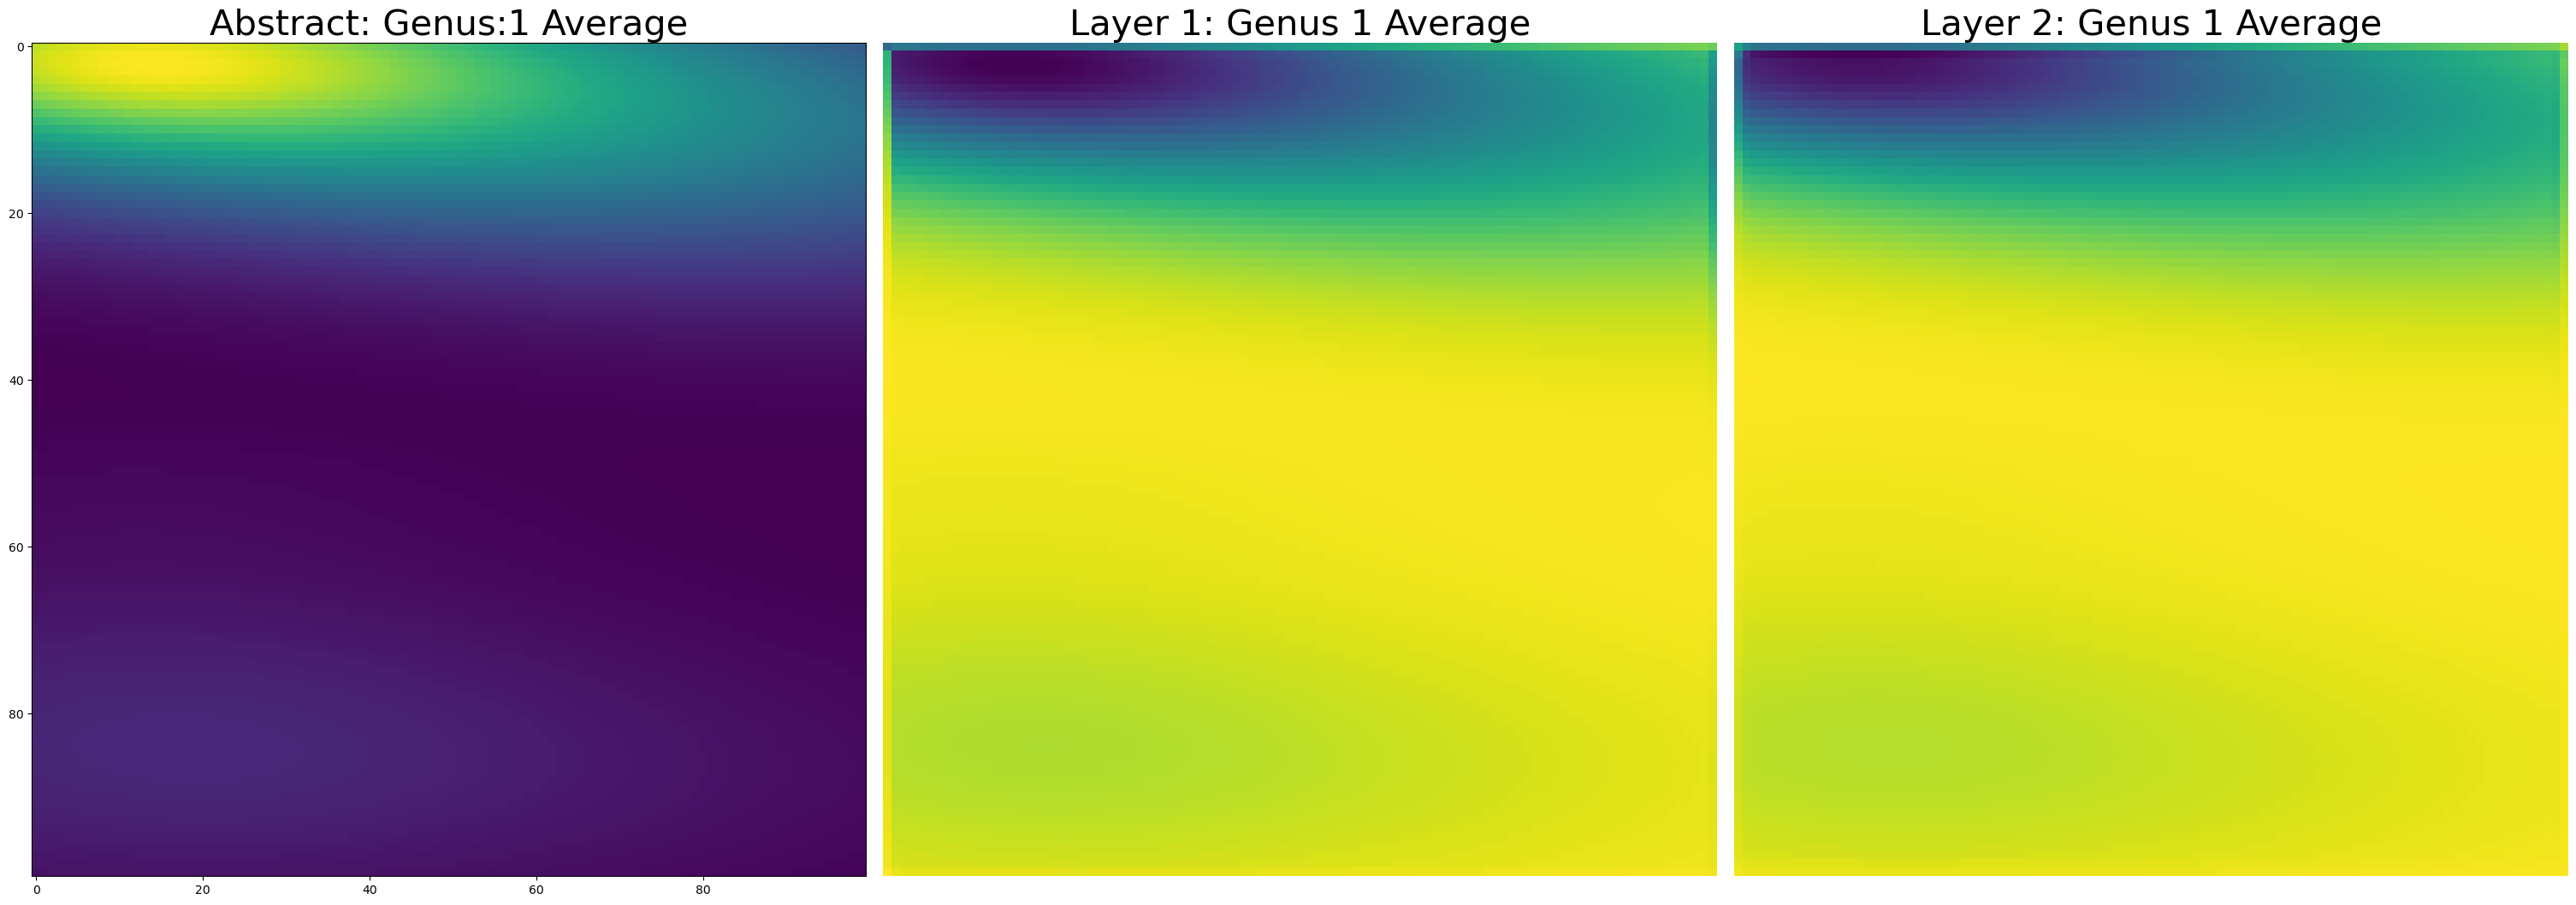

In [51]:
average_visualization(model_dual_lap_abstract_uni_nonuni, abstract1, "Abstract:", 1)

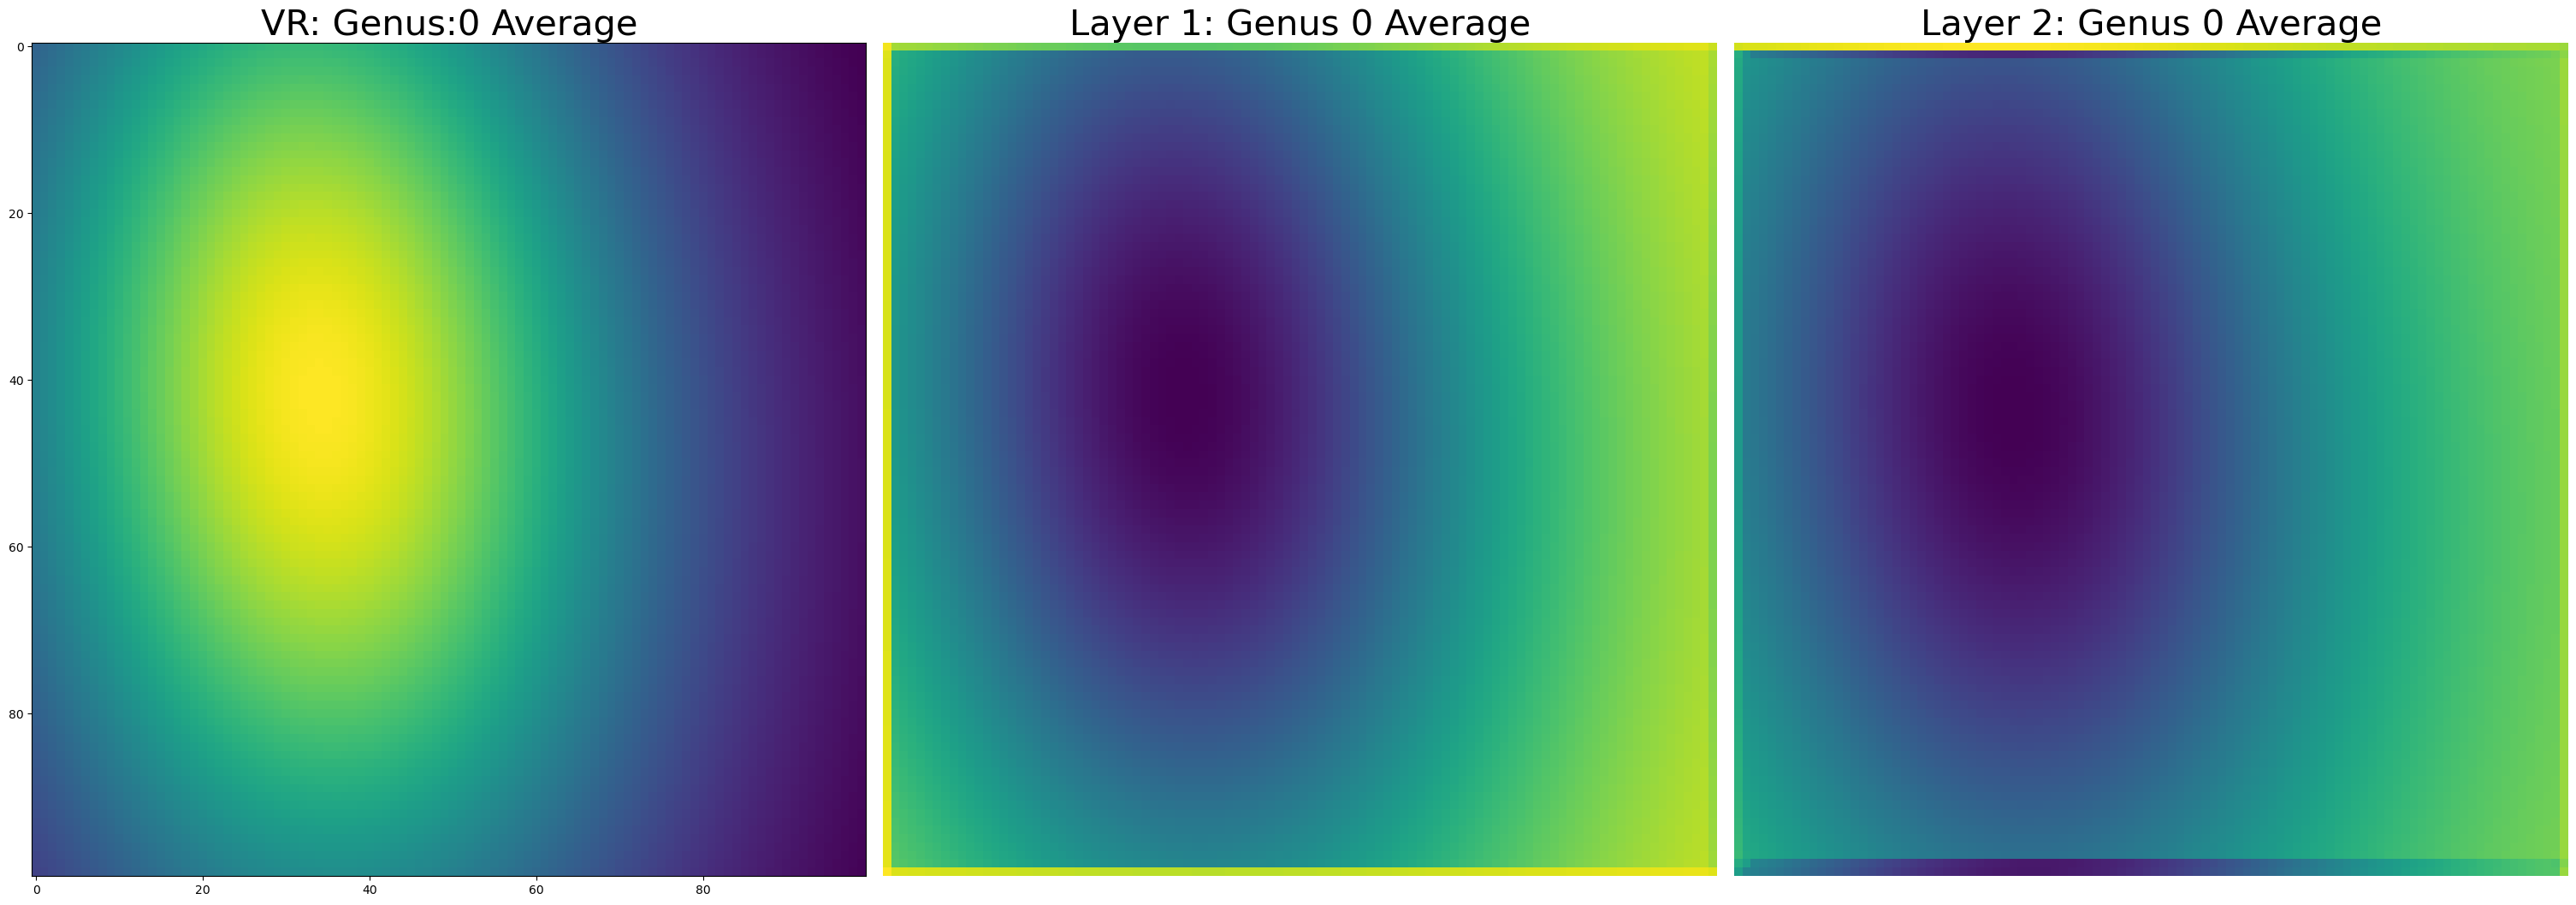

In [56]:
average_visualization(model_dual_lap_vr_uni_nonuni, vr_0, "VR:", 0)

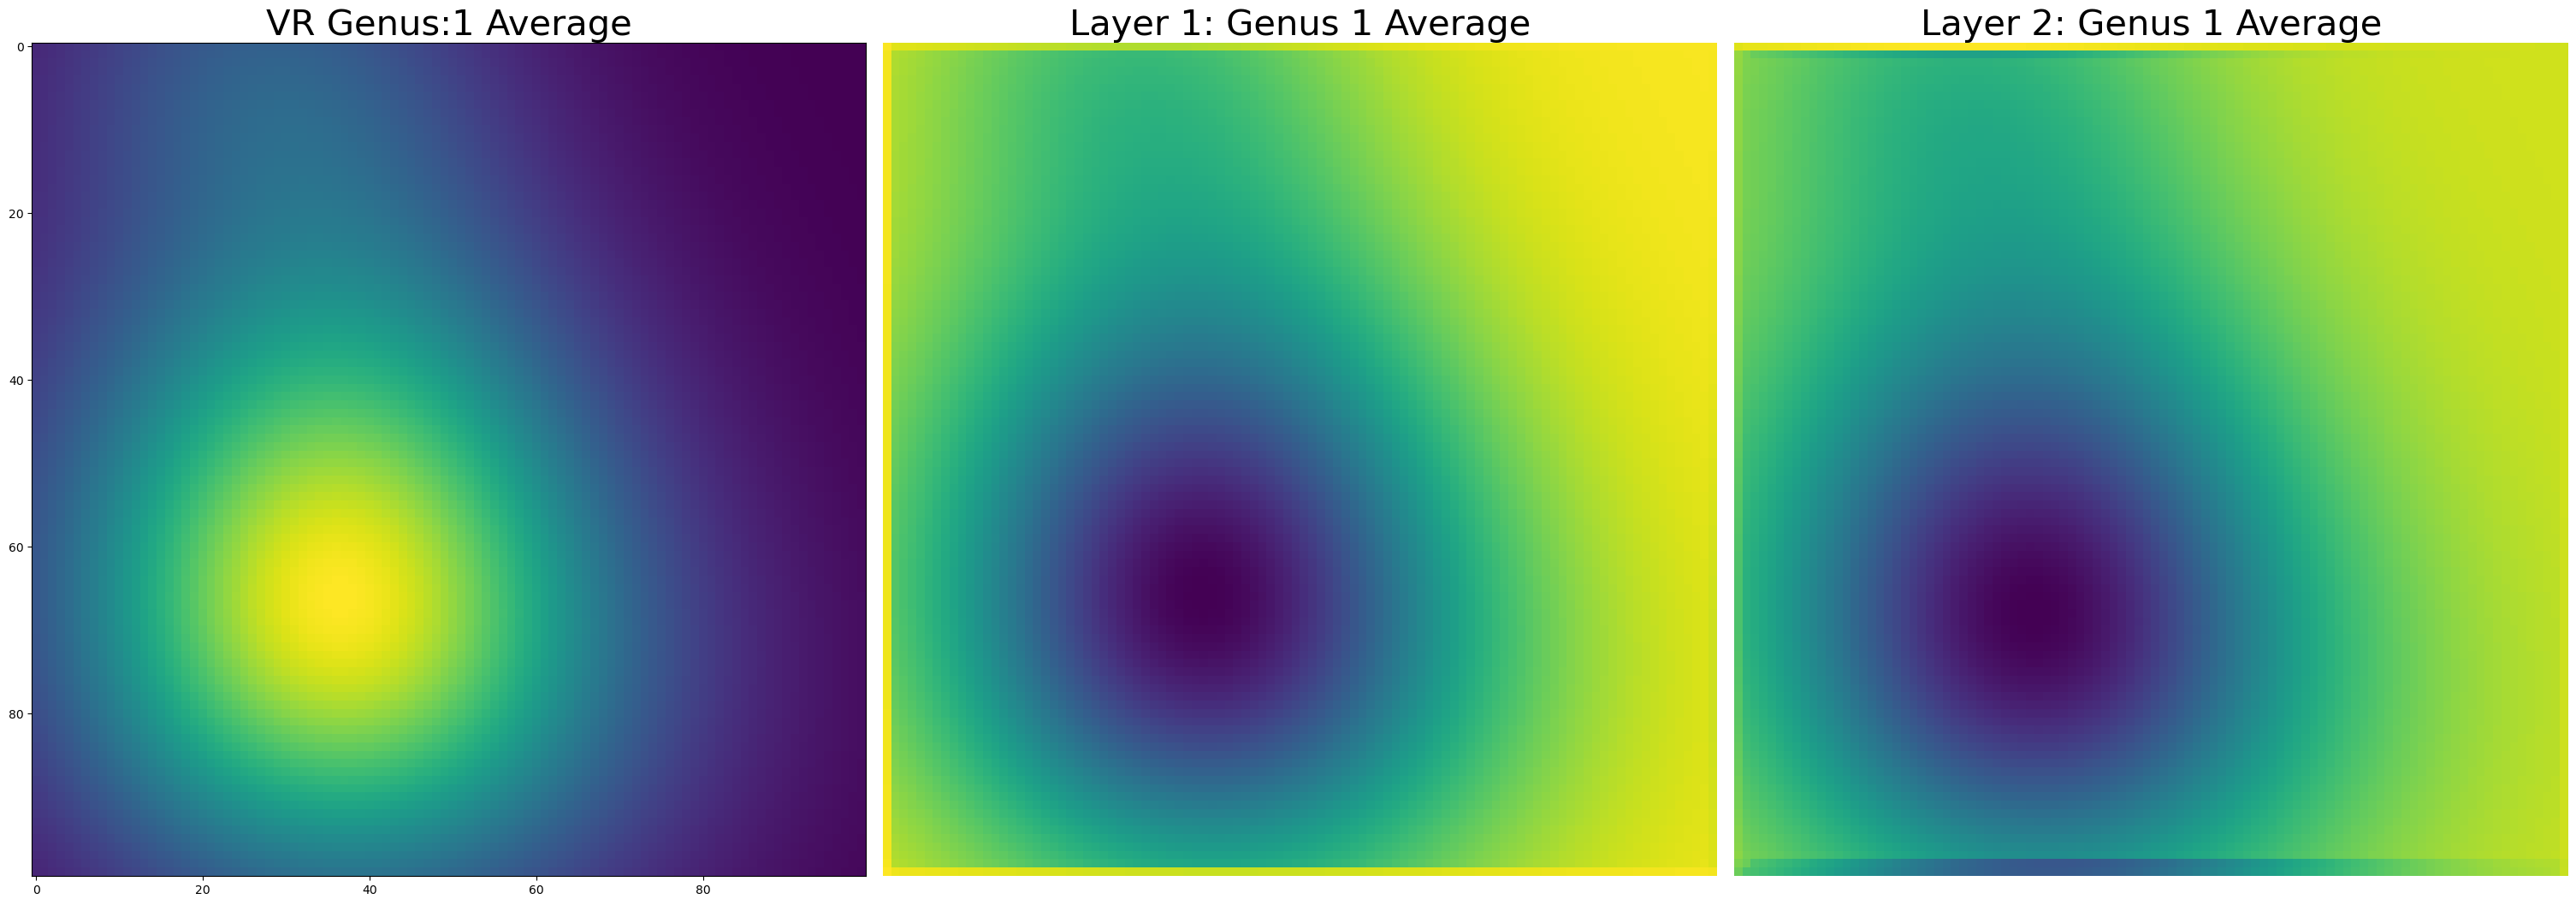

In [53]:
average_visualization(model_dual_lap_vr_uni_nonuni, vr_1, "VR", 1)

In [92]:
def feature_viz_persistance(model, data, name, d):
    model.eval()
    model_weights =[]
    conv_layers = []

    model_children = list(model.children())
    counter = 0

    for child in range(len(model_children)):
        if type(model_children[child]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[child].weight)
            conv_layers.append(model_children[child])

    image = np.float32(data)
    image = torch.tensor(image)
    outputs = []
    names = []

    for layer in conv_layers[2:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))
    #print feature_maps
    for feature_map in outputs:
        print(feature_map.shape)
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    for fm in processed:
        print(fm.shape)
    
    fig = plt.figure(figsize=(30, 50),layout='constrained')  # Large figure size
    a = fig.add_subplot(1,3,1)
    a.set_title(f"{name} {d} dimensional", fontsize=30)
    implot = plt.imshow(data[0])
    for i in range(len(processed)):
        a = fig.add_subplot(1, 3, i + 2)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(f"Conv Layer {i + 1}", fontsize=30)  # Adjust subplot title font size
    # Add a centered suptitle with adjusted position
    fig.savefig(
        f"{name}_{d}",
        bbox_inches="tight",  # Crop extra white space
        pad_inches=0.1,       # Add a small padding around the figure
        dpi=300               # Increase resolution (optional)
    )
    plt.show()

2
torch.Size([16, 100, 100])
torch.Size([32, 100, 100])
(100, 100)
(100, 100)


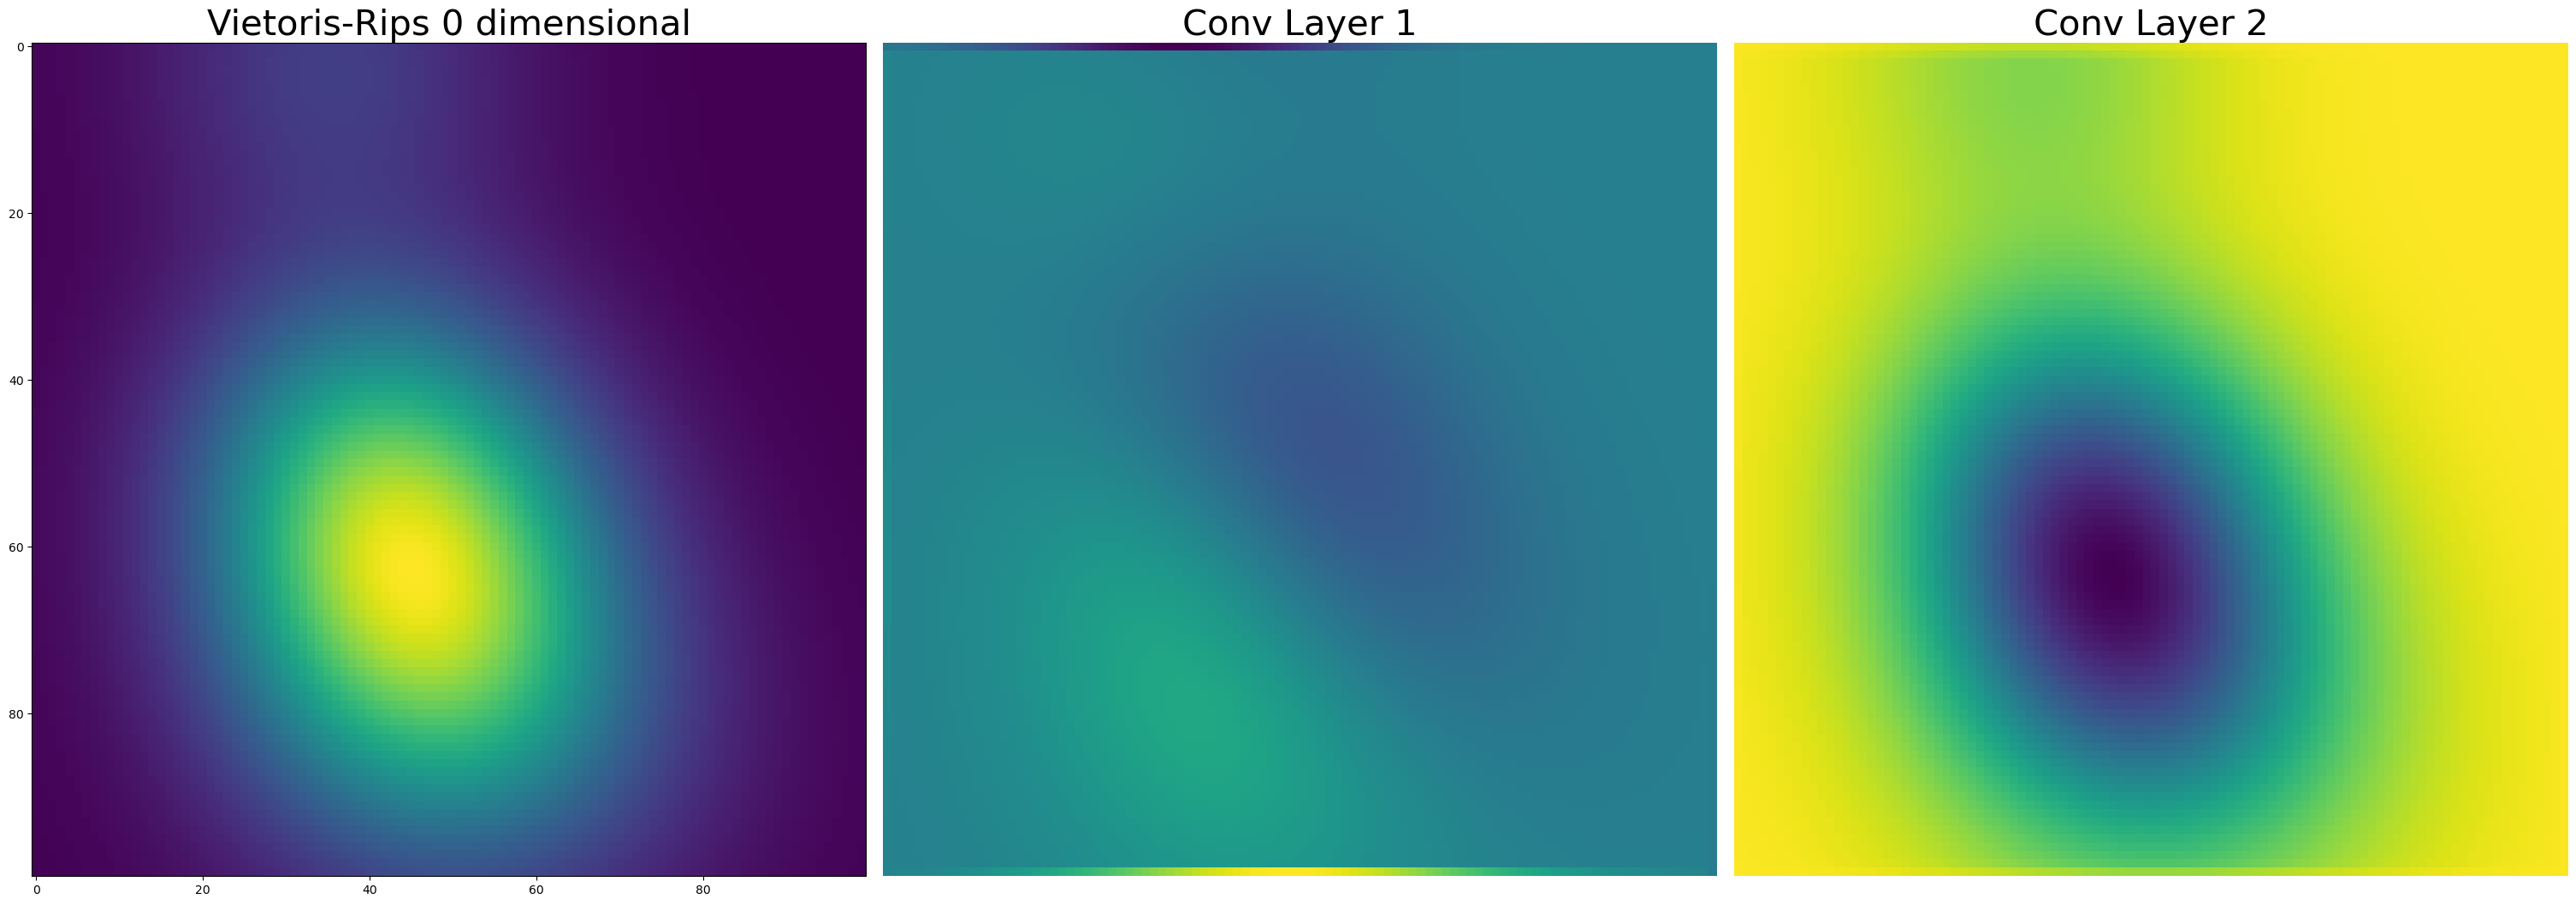

In [93]:
feature_viz_persistance(model_dual_lap_vr, vr_persistence_images, 'Vietoris-Rips', 0)

2
torch.Size([16, 100, 100])
torch.Size([32, 100, 100])
(100, 100)
(100, 100)


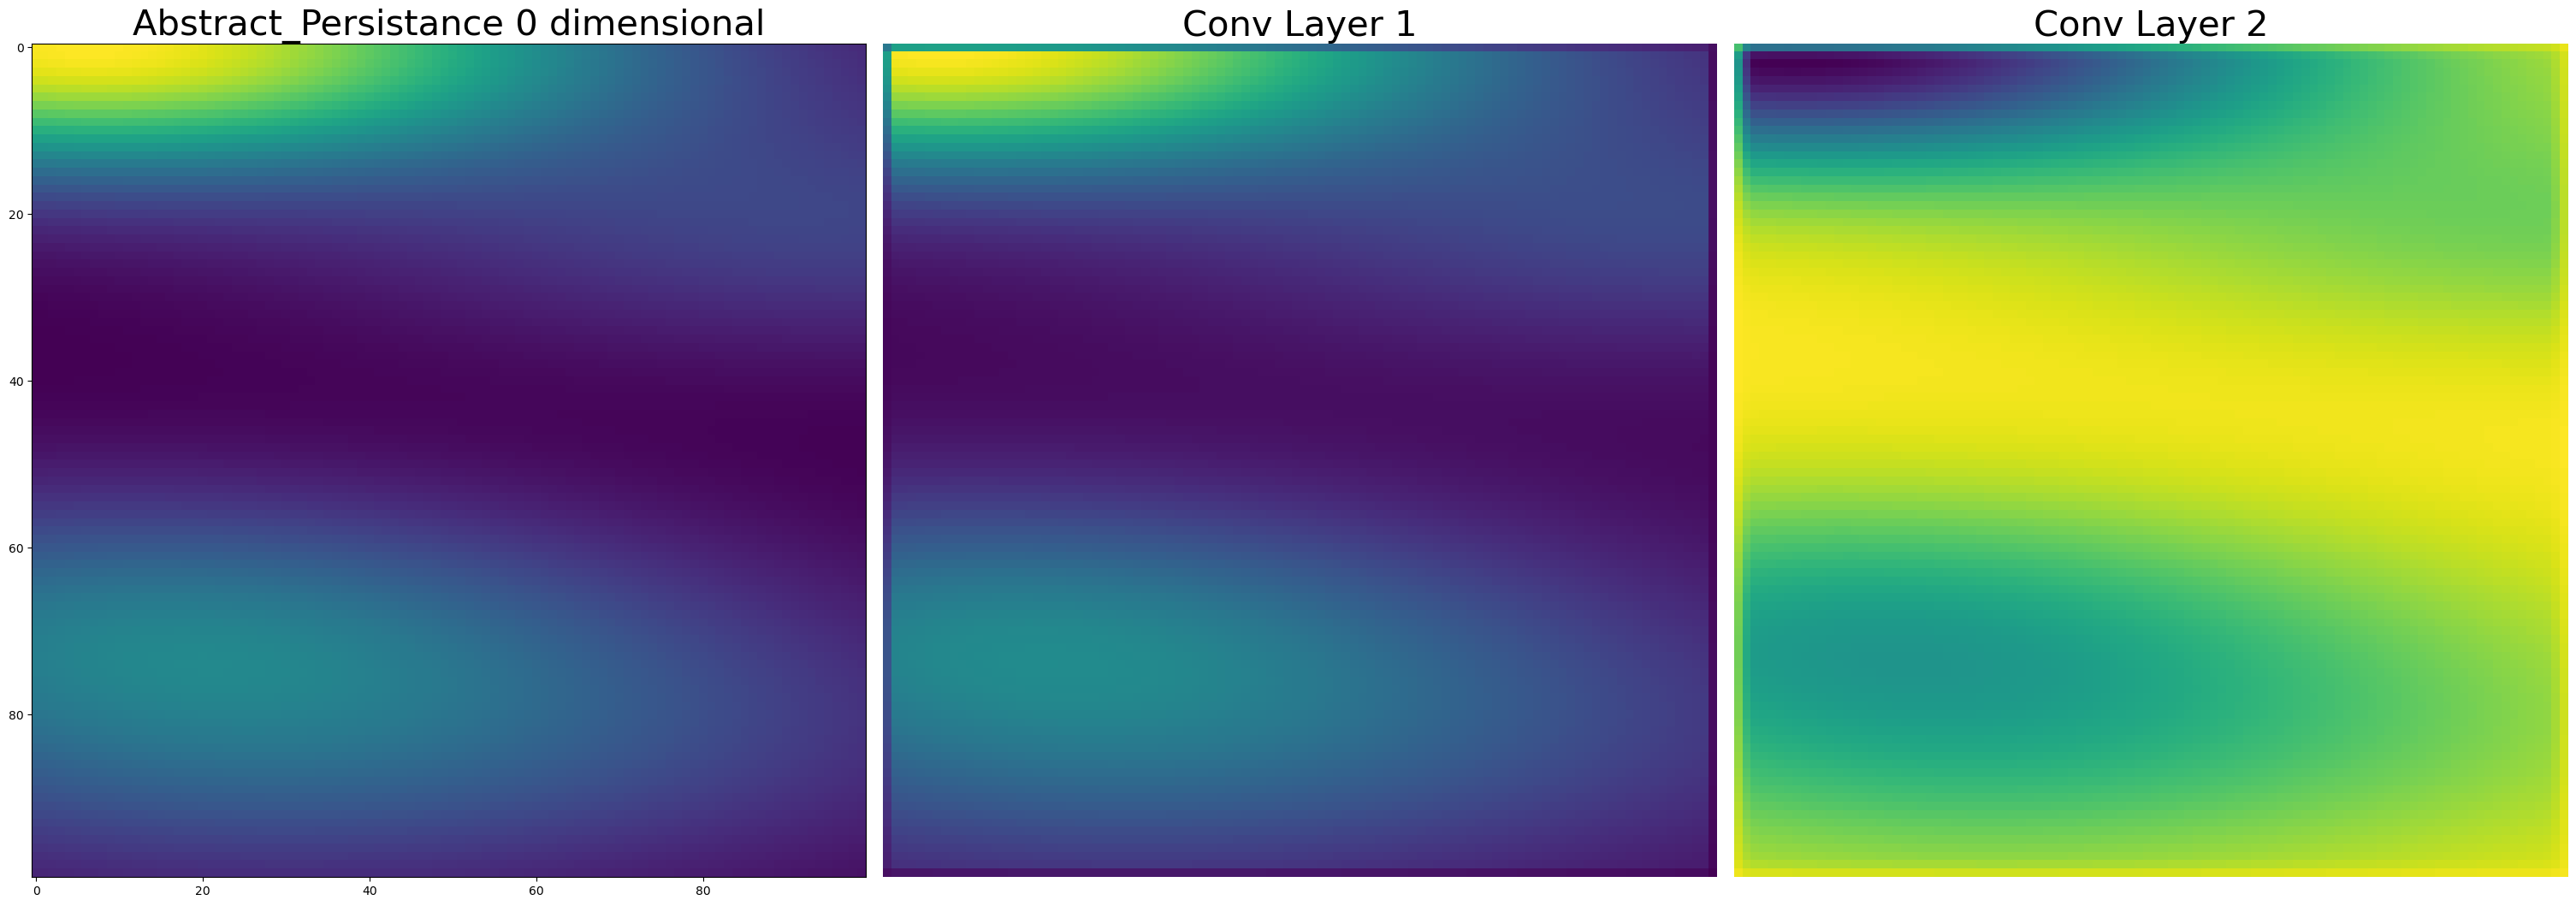

In [94]:
feature_viz_persistance(model_dual_lap_abstract, abstract_persistence_images, 'Abstract_Persistance', 0)

In [95]:
num_samples = 1 # currently set to full dataset

# Generate random indices
random_indices = [1000]
base = '../FiltrationsForGNNs/Gudhi Shape Dataset'
# Select the corresponding data and labels
laplacians = []
vr_persistence_images = []
abstract_persistence_images = []
selected_labels = []

for i in random_indices:
    laplacians.append(np.genfromtxt(f'{base}/shape_{i}_laplacian.csv', delimiter=',', skip_header=0))
    vr_persistence_images.append(np.genfromtxt(f'{base}/shape_{i}_vr_persistence_image.csv', delimiter=',', skip_header=0))
    abstract_persistence_images.append(np.genfromtxt(f'{base}/shape_{i}_abstract_persistence_image.csv', delimiter=',', skip_header=0))
    selected_labels.append(shape_labels[i])

# Convert selected labels to NumPy array
selected_labels = np.array(selected_labels)

# Print a summary
print(f"Randomly selected {num_samples} samples.")
print(f"Shape of laplacians: {np.array(laplacians).shape}")
print(f"Shape of VR persistence images: {np.array(vr_persistence_images).shape}")
print(f"Shape of abstract persistence images: {np.array(abstract_persistence_images).shape}")
print(f"Shape of selected labels: {selected_labels.shape}")

Randomly selected 1 samples.
Shape of laplacians: (1, 1000, 1000)
Shape of VR persistence images: (1, 100, 100)
Shape of abstract persistence images: (1, 100, 100)
Shape of selected labels: (1,)


2
torch.Size([16, 100, 100])
torch.Size([32, 100, 100])
(100, 100)
(100, 100)


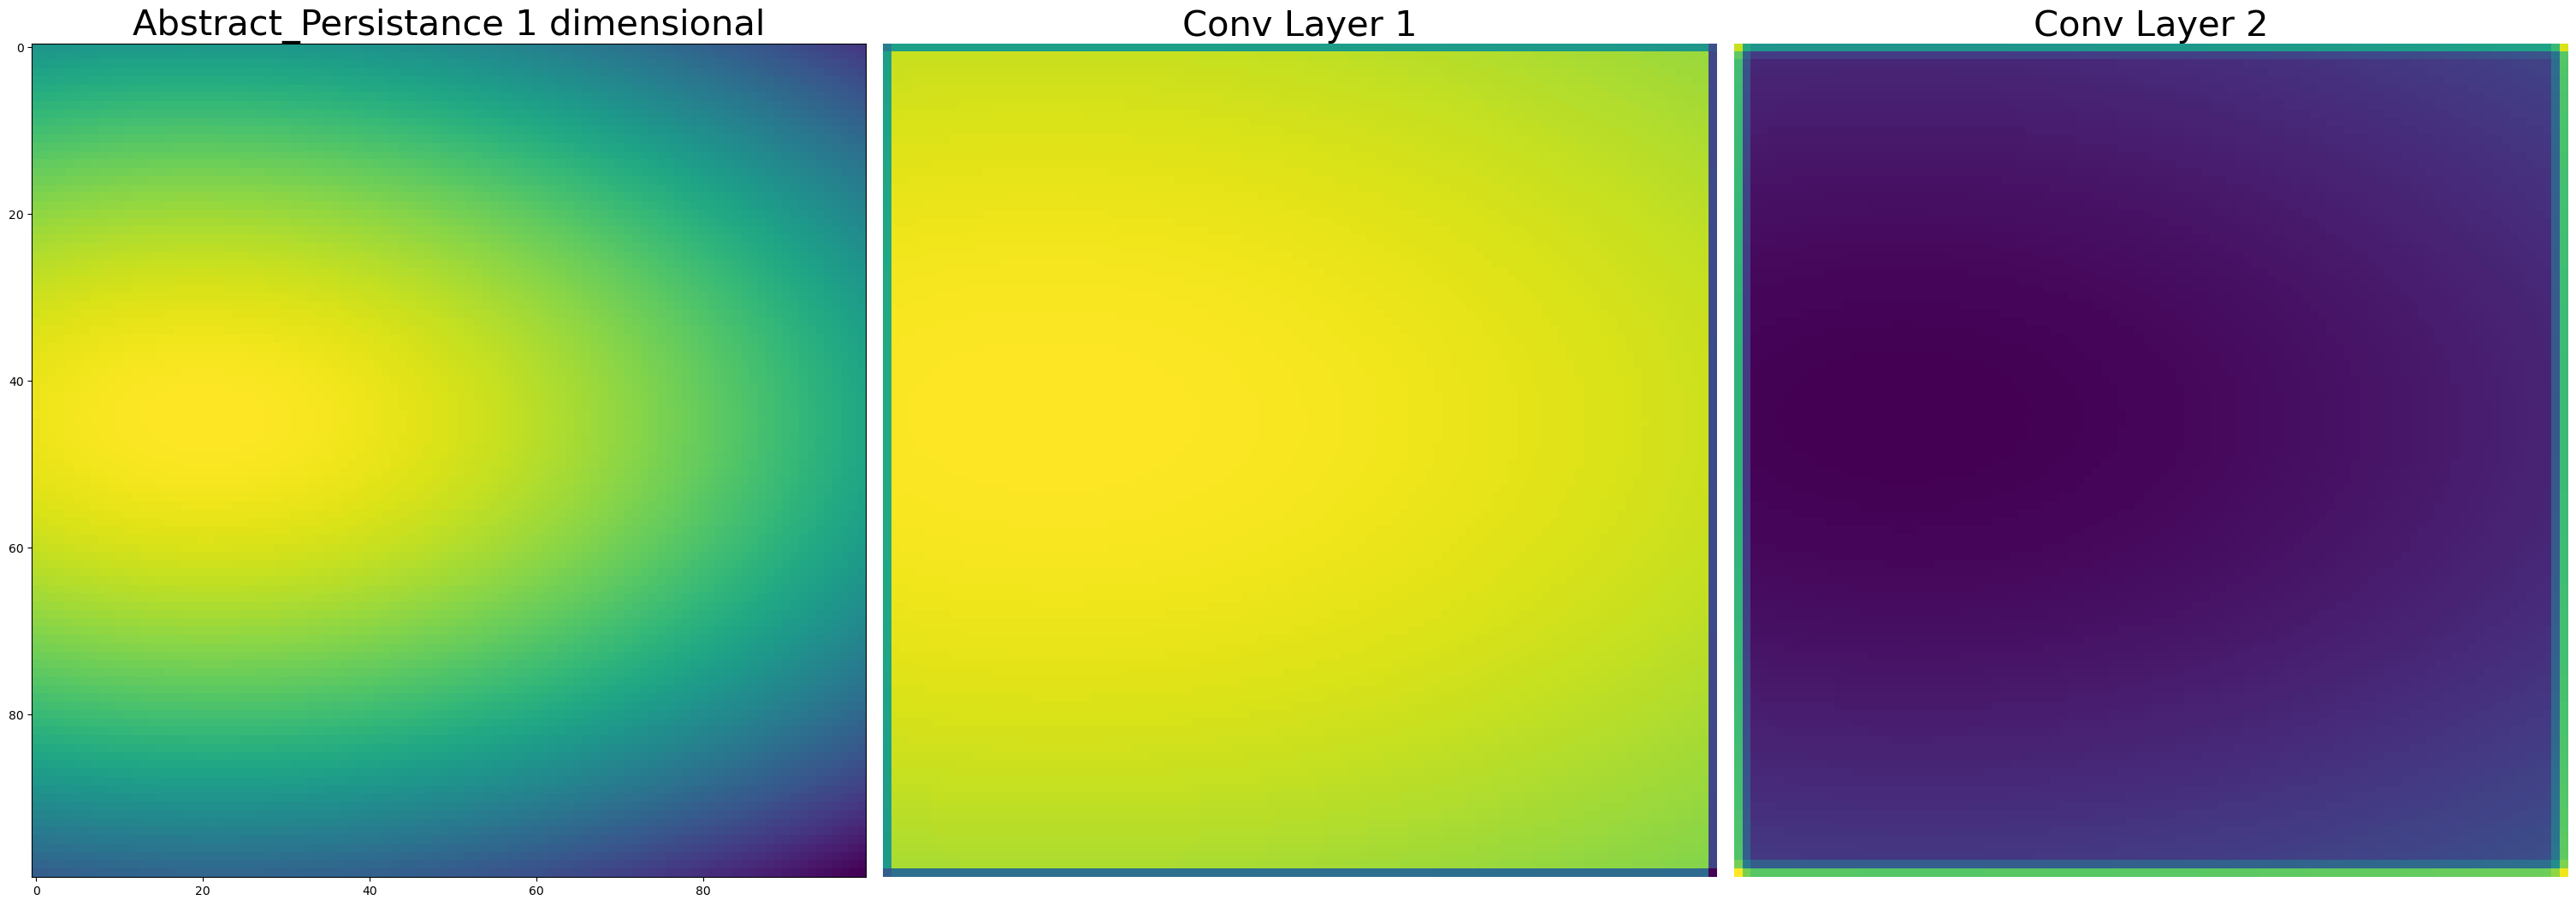

In [96]:
feature_viz_persistance(model_dual_lap_abstract, abstract_persistence_images, "Abstract_Persistance", 1)

2
torch.Size([16, 100, 100])
torch.Size([32, 100, 100])
(100, 100)
(100, 100)


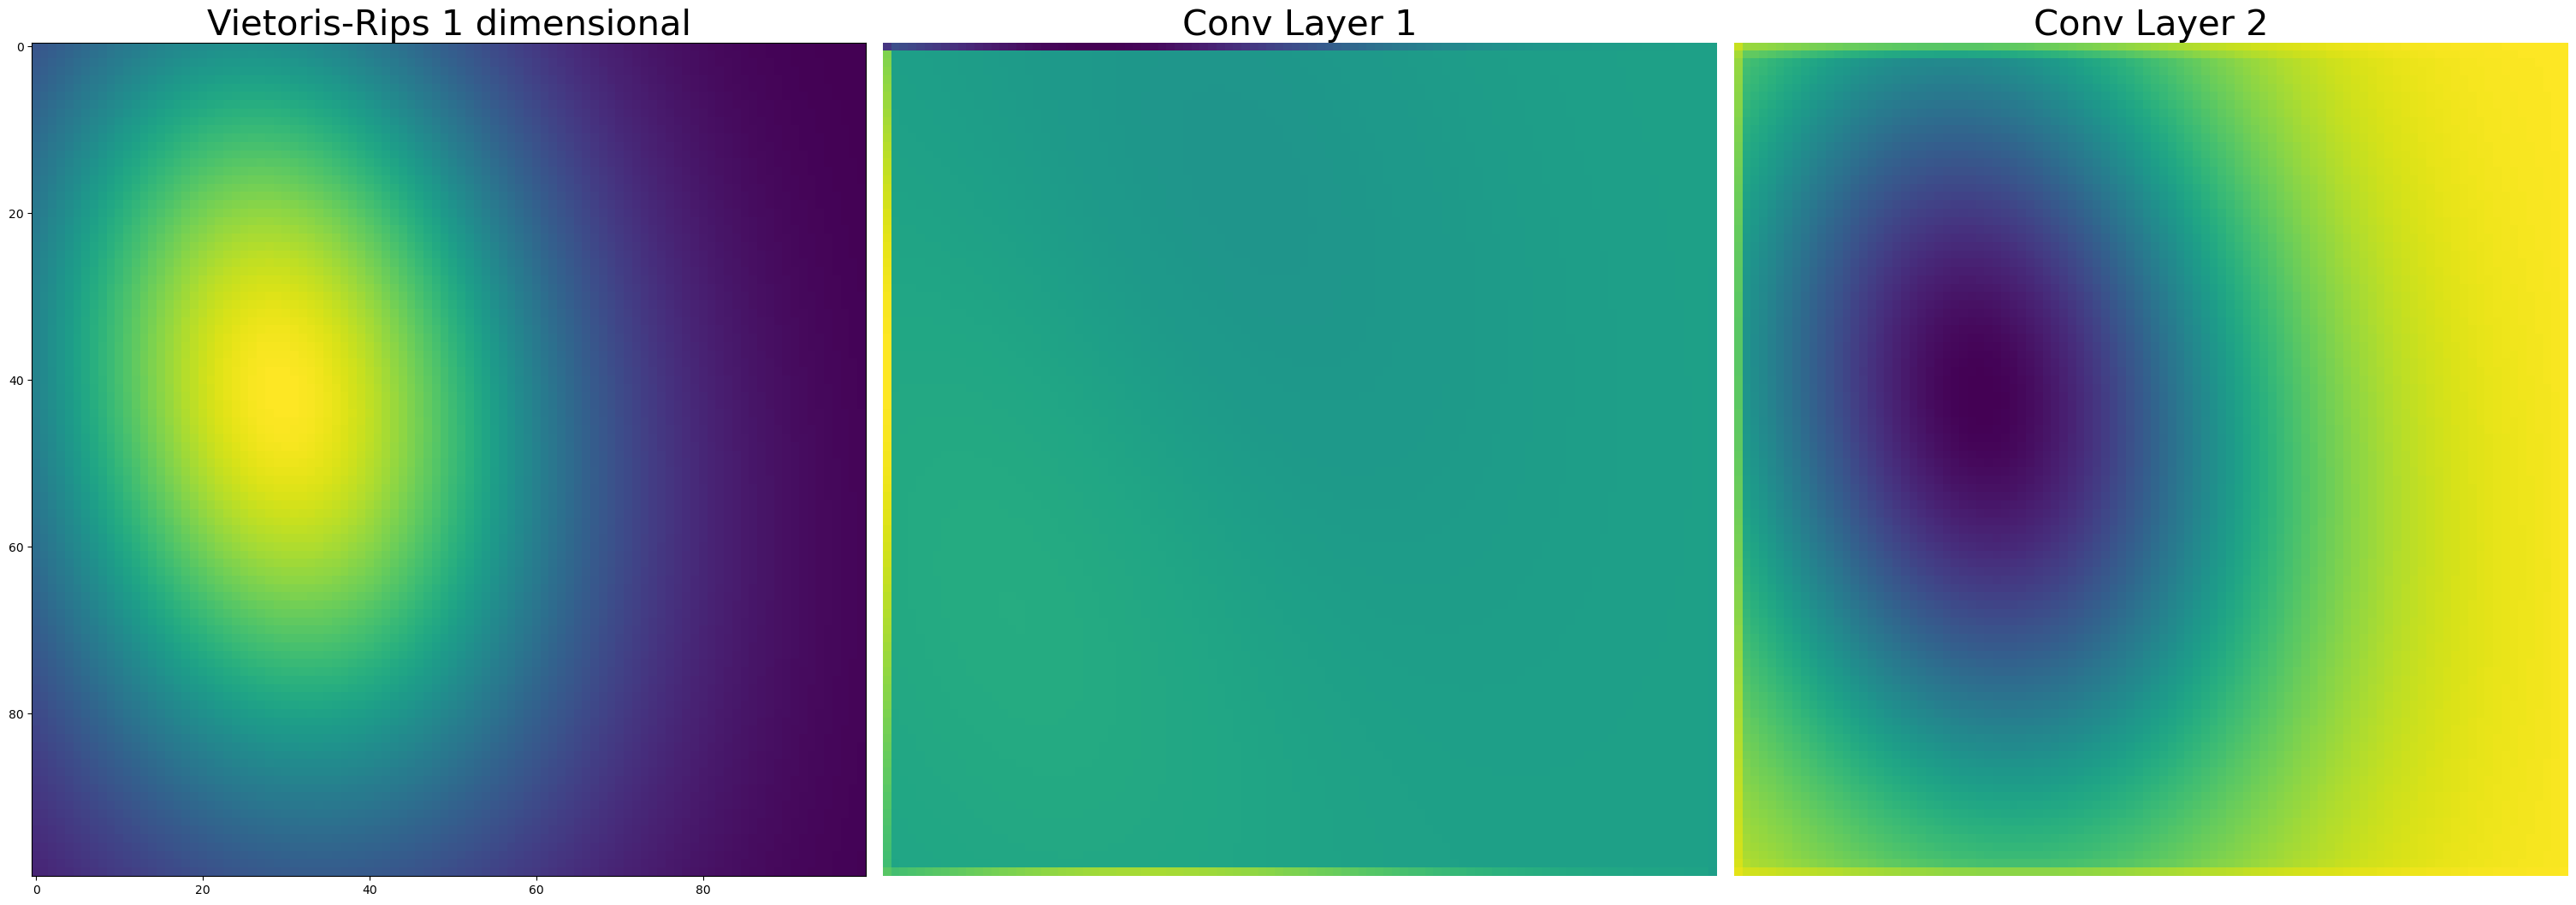

In [97]:
feature_viz_persistance(model_dual_lap_vr, vr_persistence_images, "Vietoris-Rips", 1)

2
torch.Size([16, 1000, 1000])
torch.Size([32, 1000, 1000])
(1000, 1000)
(1000, 1000)


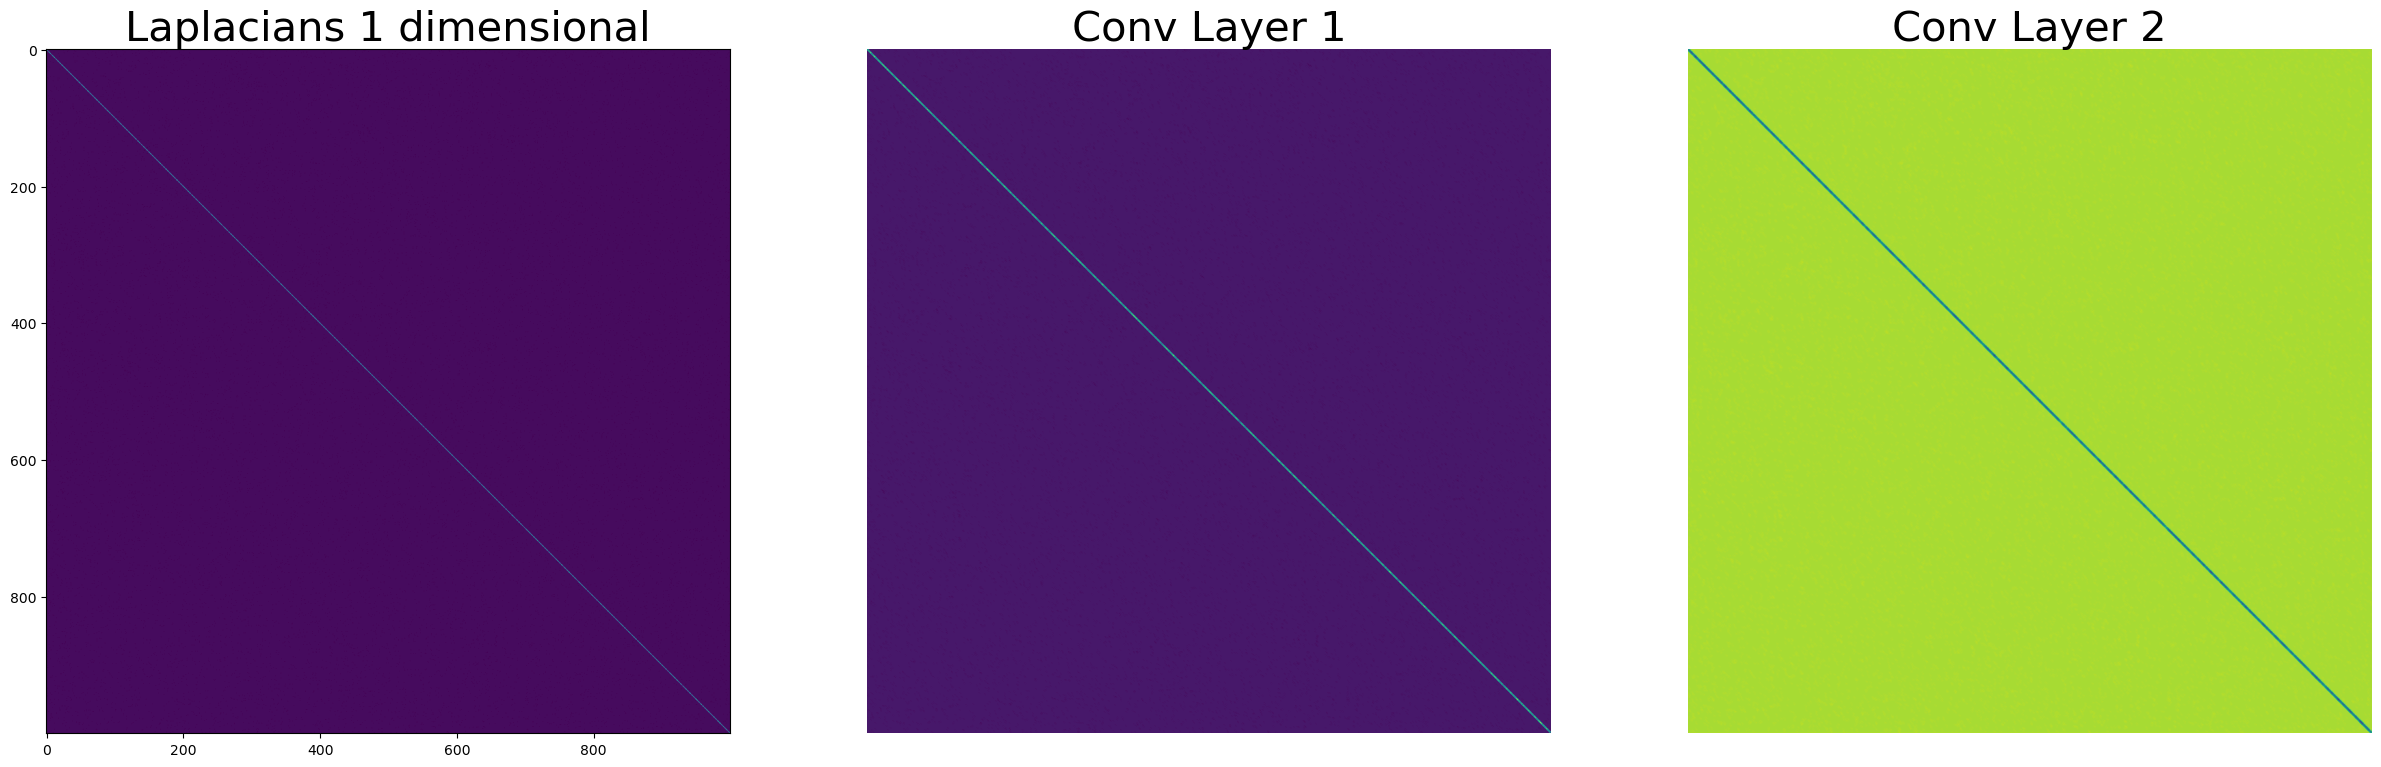

In [98]:
single_viz(lap, laplacians, "Laplacians", 1)